## Import Libs

In [1]:
from google.colab import drive
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import time
import os
from PIL import Image
from PIL import Image
import numpy as np
import pandas as pd

Using TensorFlow backend.


## Download Data

In [2]:
!rm -rf gangengo
!git clone https://github.com/timlyrics/gangengo
!mv gangengo/* .

Cloning into 'gangengo'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 38 (delta 16), reused 30 (delta 11), pack-reused 0
Unpacking objects: 100% (38/38), done.


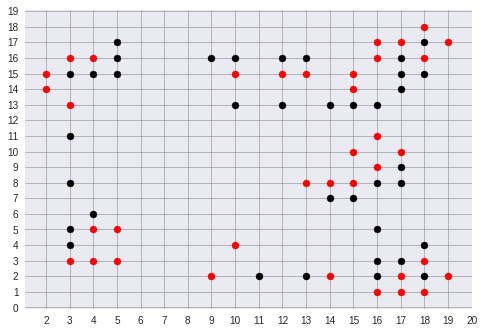

In [3]:
from gen_go import GenGo
gg = GenGo()
gg.show_random()

## Set up network parameters
 

In [0]:
img_rows = 20
img_cols = img_rows
channels = 2
img_shape = (img_rows, img_cols, channels)
latent_dim = 32

## Define a function to build a generator

In [0]:
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 5 * 5, activation="relu", input_dim=latent_dim))
    model.add(Reshape((5, 5, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("sigmoid"))
    model.summary()
    noise = Input(shape=(latent_dim,))
    img = model(noise)
    m = Model(noise, img)
    return m

## Define a function to build a discriminator

In [0]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="valid"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

## Build GAN

In [7]:
# build discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.00002, 0.3, decay=1e-6),
                      metrics=['accuracy'])

# build generator
generator = build_generator()
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.9))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 9, 32)          608       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_1

## Transform between softmax space and linear space

In [0]:
def softmax_from_linear(arr):
  arr = np.expand_dims(arr, axis=3)
  smx = np.concatenate([1 * (arr > 0), 1 * (arr < 0)], axis=3)
  return smx

def linear_from_softmax(smx):
  arr = ((smx[:,:,:,0] > 0.5) & (smx[:,:,:,0] > smx[:,:,:,1])) * 1 + ((smx[:,:,:,1] > 0.5) & (smx[:,:,:,1] > smx[:,:,:,0])) * -1
  return arr

## Define a function to train GAN

In [0]:
def train(epochs, batch_size, save_interval):
    os.makedirs('images', exist_ok=True)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # losses
    arr_d_loss = np.zeros(epochs)
    arr_g_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        # Select a random real images
        real_imgs = softmax_from_linear(gg.arr_from_random(batch_size))

        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)
        
        # Train the discriminator
        D_loss_real = discriminator.train_on_batch(real_imgs, valid)
        D_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid)
        
        # Remember loss
        arr_d_loss[epoch] = D_loss[0]
        arr_g_loss[epoch] = float(g_loss)

        # If at save interval
        if epoch % save_interval == 0:
            # Print the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, D_loss[0], 100 * D_loss[1], g_loss))
            # Save generated image samples
            save_imgs(epoch)

    return arr_d_loss, arr_g_loss

## Define visualizer

In [0]:
def save_imgs(epoch):
    r, c = 3, 3
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = linear_from_softmax(generator.predict(noise))

    fig, axs = plt.subplots(r, c)
    fig.set_figheight(10)
    fig.set_figwidth(10)

    cnt = 0
    for i in range(r):
        for j in range(c):
            row = gen_imgs[cnt, :, :]
            cnt += 1
            
            ax = axs[i, j]
            loc = MultipleLocator(base=1)
            ax.xaxis.set_major_locator(loc)
            ax.yaxis.set_major_locator(loc)
            ax.set_axisbelow(True)
            ax.grid(linestyle='-', axis='both', linewidth='0.5', color='grey')
            for x in range(row.shape[0]):
                for y in range(row.shape[1]):
                    if row[x][y] > 0.5:
                        ax.scatter(x, y, c='red', s=50)
                    elif row[x][y] < -0.5:
                        ax.scatter(x, y, c='black', s=50)

    fig.savefig("images/go_%d.png" % epoch)
    plt.close()

## Train GAN

In [11]:
start = time.time()

arr_d_loss, arr_g_loss = train(epochs=100001, batch_size=128, save_interval=500)

end = time.time()
elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                     int((end - start) % 60))
print(elapsed_train_time)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.789266, acc.: 49.61%] [G loss: 0.998815]
500 [D loss: 0.311758, acc.: 89.06%] [G loss: 1.922222]
1000 [D loss: 0.518030, acc.: 75.00%] [G loss: 1.457009]
1500 [D loss: 0.509538, acc.: 74.61%] [G loss: 1.229731]
2000 [D loss: 0.608274, acc.: 66.80%] [G loss: 1.199285]
2500 [D loss: 0.694906, acc.: 64.45%] [G loss: 1.168440]
3000 [D loss: 0.650478, acc.: 64.45%] [G loss: 1.103487]
3500 [D loss: 0.766950, acc.: 54.30%] [G loss: 0.804478]
4000 [D loss: 0.613882, acc.: 65.62%] [G loss: 0.943929]
4500 [D loss: 0.645449, acc.: 63.28%] [G loss: 0.846949]
5000 [D loss: 0.693054, acc.: 58.59%] [G loss: 0.856569]
5500 [D loss: 0.720260, acc.: 53.52%] [G loss: 0.922082]
6000 [D loss: 0.634493, acc.: 63.28%] [G loss: 0.821826]
6500 [D loss: 0.769662, acc.: 47.66%] [G loss: 0.861496]
7000 [D loss: 0.713239, acc.: 59.38%] [G loss: 0.843890]
7500 [D loss: 0.714131, acc.: 53.91%] [G loss: 0.742113]
8000 [D loss: 0.680769, acc.: 57.81%] [G loss: 0.761326]
8500 [D loss: 0.705026, acc.: 55.47

Text(0, 0.5, 'loss')

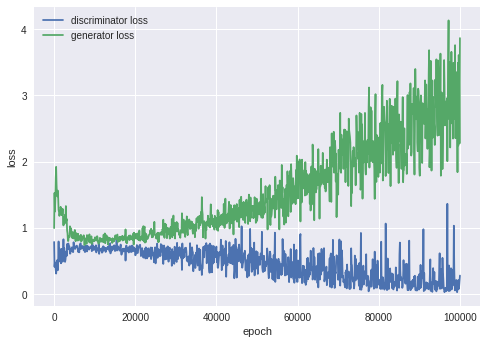

In [27]:
plt.plot(np.arange(1001) * 100, arr_d_loss[::100])
plt.plot(np.arange(1001) * 100, arr_g_loss[::100])
plt.legend(['discriminator loss', 'generator loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [0]:
os.makedirs('saved_model_weights', exist_ok=True)
generator.save_weights('saved_model_weights/generator_weights.h5')
discriminator.save_weights('saved_model_weights/discriminator_weights.h5')
combined.save_weights('saved_model_weights/combined_weights.h5')

In [0]:
# debugging
noise = np.random.normal(0, 1, (1, latent_dim))
raw = generator.predict(noise)
gen_imgs = linear_from_softmax(generator.predict(noise))

In [0]:
# debugging
a = raw[0,:,:]
(a[:,:,0] < 0.5) & (a[:,:,1] < 0.5)

b = softmax_from_linear(gg.arr_from_random(1))

## Show generated GO

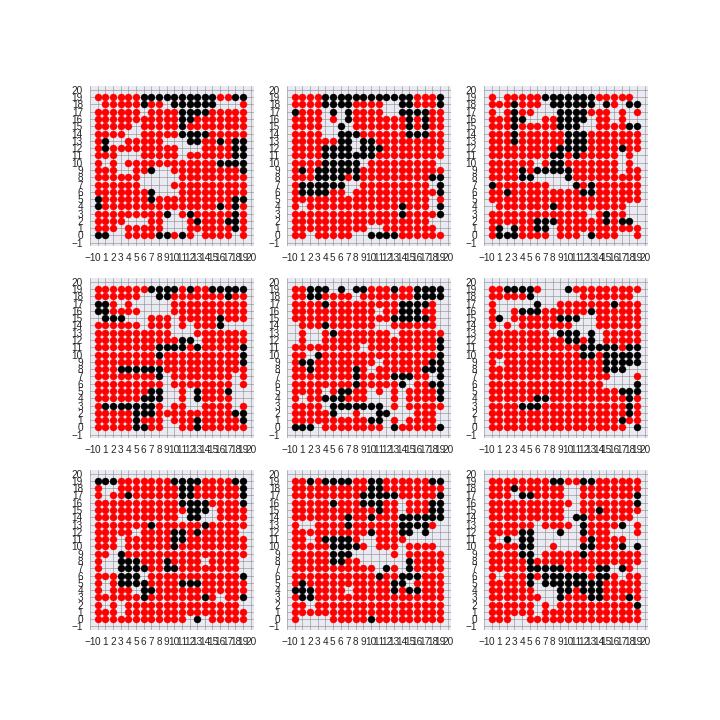

In [16]:
Image.open('images/go_0.png')

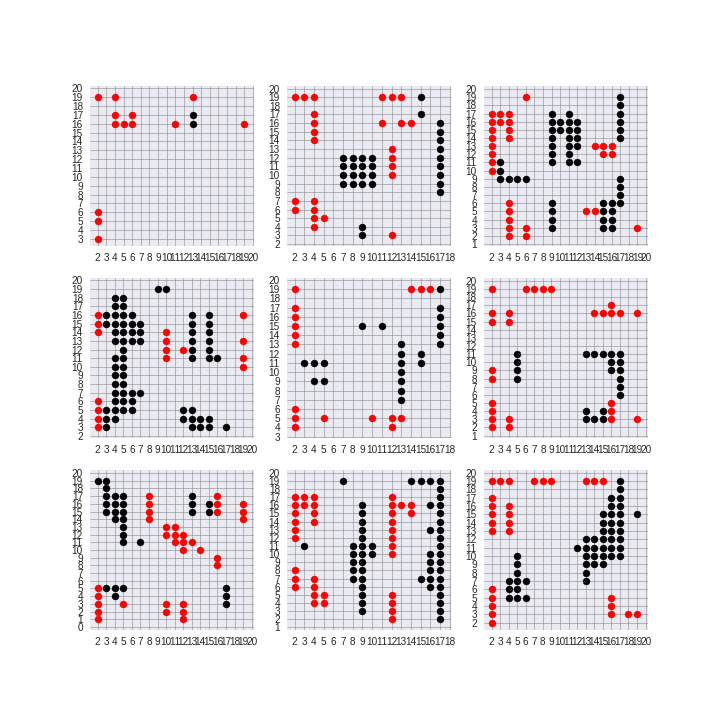

In [18]:
Image.open('images/go_500.png')

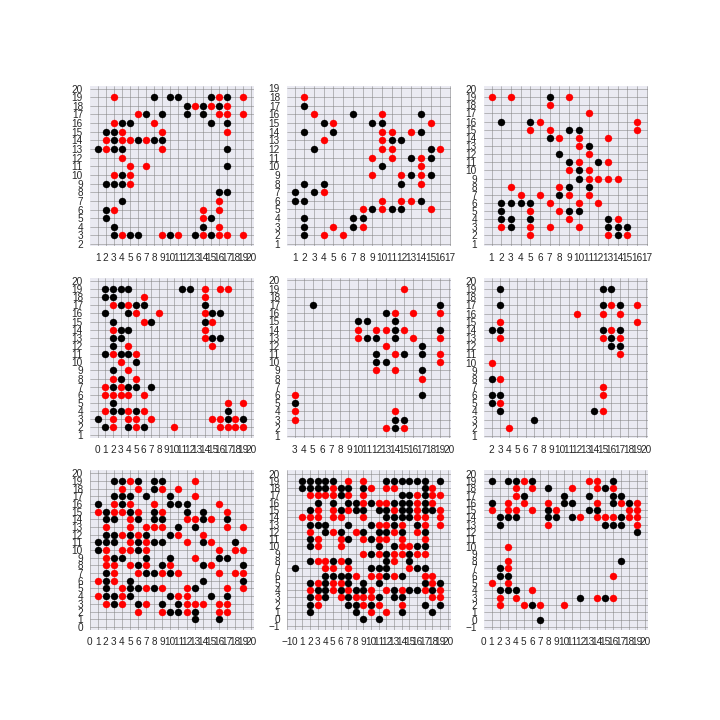

In [19]:
Image.open('images/go_5000.png')

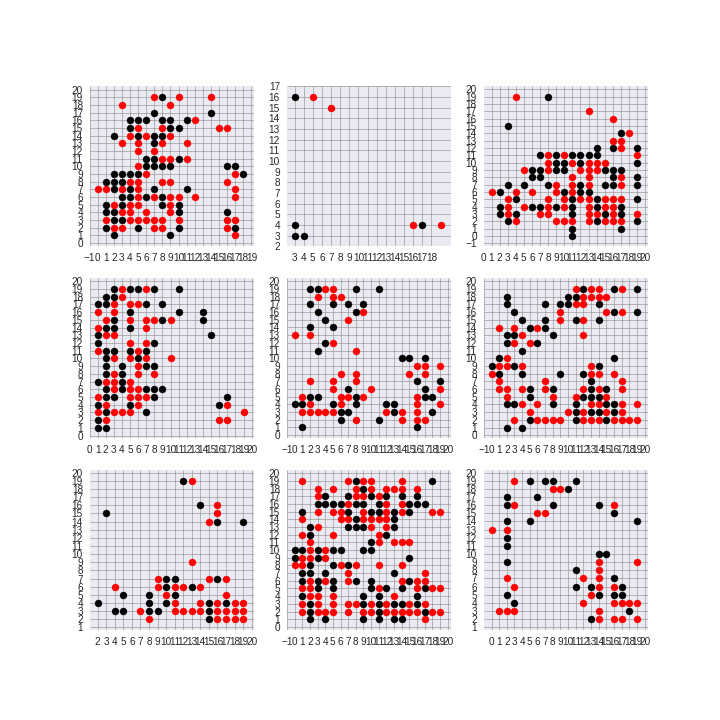

In [20]:
Image.open('images/go_20000.png')

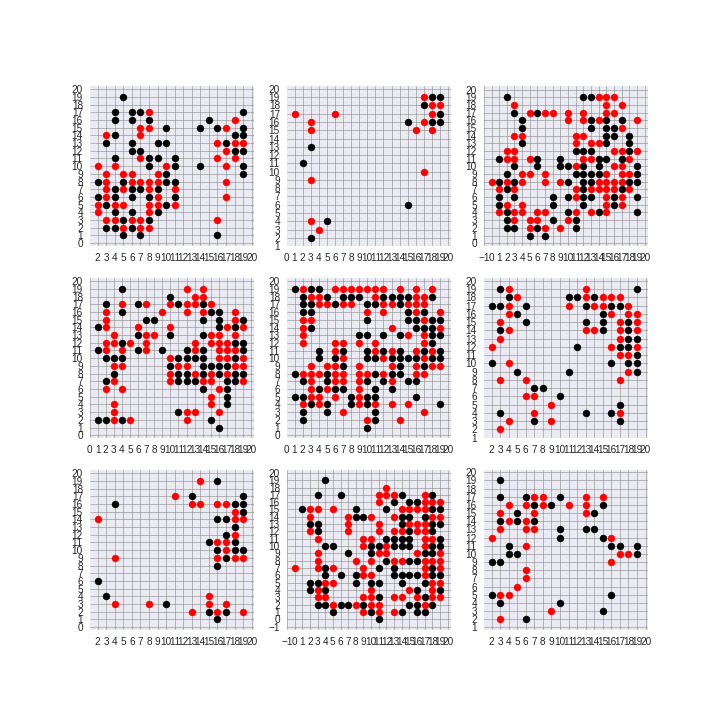

In [21]:
Image.open('images/go_50000.png')

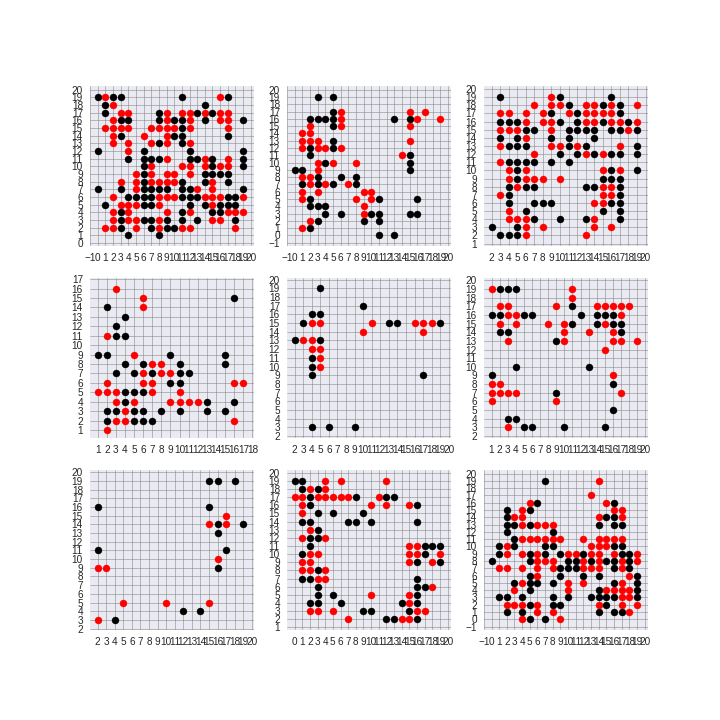

In [22]:
Image.open('images/go_100000.png')

## Reference
[Keras - DCGAN](https://github.com/eriklindernoren/Keras-GAN#dcgan)